In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from math import sqrt
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, cross_validate
from scipy.spatial.distance import cdist

# Προετοιμασία δεδομένων.

Διαγραφή της στήλης timestamp απο τον πίνακα ratings (αρχείο u.data) και εισαγωγή ονομάτων στις στήλες για κάθε σύνολο δεδομένων.

In [1]:
movies = pd.read_csv('ml-latest-small-100K/movies.csv')

ratings = pd.read_csv('ml-latest-small-100K/ratings.csv')
ratings = ratings.drop('timestamp', axis=1)

NameError: name 'pd' is not defined

Στο σετ δεδομένων movies (u.item), υπάρχουν οι στήλες:

*['movie_id', 'title', 'release_date', 'video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']*,

αλλα εμείς κρατάμε μόνο τις στήλες *[movie_id και title]*, μιας και είναι οι μόνες που χρειάζονται στον αλγόριθμο **Collaborative Filtering**

In [ ]:
print(movies)
print(f"\nΣύνολο διαφορετικών ταινιών στο Dataset: {len(movies)}.")
movies[movies['movieId'] == 318].head()

      movieId                                      title  \
0           1                           Toy Story (1995)   
1           2                             Jumanji (1995)   
2           3                    Grumpier Old Men (1995)   
3           4                   Waiting to Exhale (1995)   
4           5         Father of the Bride Part II (1995)   
...       ...                                        ...   
9737   193581  Black Butler: Book of the Atlantic (2017)   
9738   193583               No Game No Life: Zero (2017)   
9739   193585                               Flint (2017)   
9740   193587        Bungo Stray Dogs: Dead Apple (2018)   
9741   193609        Andrew Dice Clay: Dice Rules (1991)   

                                           genres  
0     Adventure|Animation|Children|Comedy|Fantasy  
1                      Adventure|Children|Fantasy  
2                                  Comedy|Romance  
3                            Comedy|Drama|Romance  
4                  

,movieId,title,genres
277,318,"Shawshank Redemption, The (1994)",Crime|Drama


Στο σετ δεδομένων ratings (u.data), υπάρχουν οι βαθμολογίες του κάθε χρήστη για τις ταινίες.

In [ ]:
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


Ένωση πινάκων **ratings** και **movies** με άξονα το **movie_id**.

In [ ]:
dataset = pd.merge(ratings, movies, on="movieId")
dataset.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


Ψάχνοντας στην ένωση πινάκων, μπορούμε να δούμε ο,τι ο χρήστης **611**, βαθμολόγησε τη ταινία με όνομα: *Interstellar (2014)*, με **5/5**.

Επίσης μπορούμε να δούμε οτι ο βαθμολόγησε άλλες 10 ταινίες.

In [ ]:
movie_title_to_explore = "Interstellar (2014)"
dataset[(dataset['title'] == movie_title_to_explore) & (dataset['userId'] == 611)]

,userId,movieId,rating,title,genres
17982,611,109487,5.0,Interstellar (2014),Sci-Fi|IMAX


In [ ]:
dataset[(dataset['userId'] == 611)].head(10)

,userId,movieId,rating,title,genres
1819,611,260,5.0,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
3427,611,480,4.0,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
5542,611,780,5.0,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller
11419,611,2116,5.0,"Lord of the Rings, The (1978)",Adventure|Animation|Children|Fantasy
12924,611,2571,4.5,"Matrix, The (1999)",Action|Sci-Fi|Thriller
17218,611,58559,5.0,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX
17611,611,79132,5.0,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX
17982,611,109487,5.0,Interstellar (2014),Sci-Fi|IMAX
18099,611,122882,4.5,Mad Max: Fury Road (2015),Action|Adventure|Sci-Fi|Thriller
25022,611,4896,4.0,Harry Potter and the Sorcerer's Stone (a.k.a. ...,Adventure|Children|Fantasy


In [ ]:
print(f"Μέση βαθμολογία για την ταινία: {movie_title_to_explore}.\n{dataset[(dataset['title'] == movie_title_to_explore)]['rating'].mean()}")

Μέση βαθμολογία για την ταινία: Interstellar (2014).
4.006756756756757


In [ ]:
dataset['title'].value_counts()[0:10]

title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Matrix, The (1999)                           279
Silence of the Lambs, The (1991)             279
Star Wars: Episode IV - A New Hope (1977)    252
Jurassic Park (1993)                         239
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            225
Schindler's List (1993)                      220
Name: count, dtype: int64

# Εξερεύνηση Δεδομένων

In [ ]:
complete_movie_stats = dataset.groupby('title')['rating'].agg(['count', 'mean']).sort_values(by='count', ascending=False)
complete_movie_stats.head(10)

,count,mean
title,,
Forrest Gump (1994),329,4.164134
"Shawshank Redemption, The (1994)",317,4.429022
Pulp Fiction (1994),307,4.197068
"Matrix, The (1999)",279,4.193548
"Silence of the Lambs, The (1991)",279,4.161290
Star Wars: Episode IV - A New Hope (1977),252,4.234127
Jurassic Park (1993),239,3.751046
Braveheart (1995),237,4.031646
Terminator 2: Judgment Day (1991),225,3.975556


In [ ]:
complete_movie_stats[(complete_movie_stats['count'] >= 100)][0:10]

,count,mean
title,,
Forrest Gump (1994),329,4.164134
"Shawshank Redemption, The (1994)",317,4.429022
Pulp Fiction (1994),307,4.197068
"Matrix, The (1999)",279,4.193548
"Silence of the Lambs, The (1991)",279,4.161290
Star Wars: Episode IV - A New Hope (1977),252,4.234127
Jurassic Park (1993),239,3.751046
Braveheart (1995),237,4.031646
Terminator 2: Judgment Day (1991),225,3.975556


Όπως βλέπουμε, οι χρήστες είναι αρκετά γενναιόδωροι στις βαθμολογίες, με την υψηλότερη βαθμολογία (**5**) να είναι τρίτη στην κατάταξη, ως σύνολο καταγεγραμμένων βαθμολογιών για κάθε ταινία.

Κατανομή Βαθμολογίας: 
rating
0.5     1370
1.0     2811
1.5     1791
2.0     7552
2.5     5550
3.0    20053
3.5    13138
4.0    26837
4.5     8565
5.0    13229
Name: count, dtype: int64




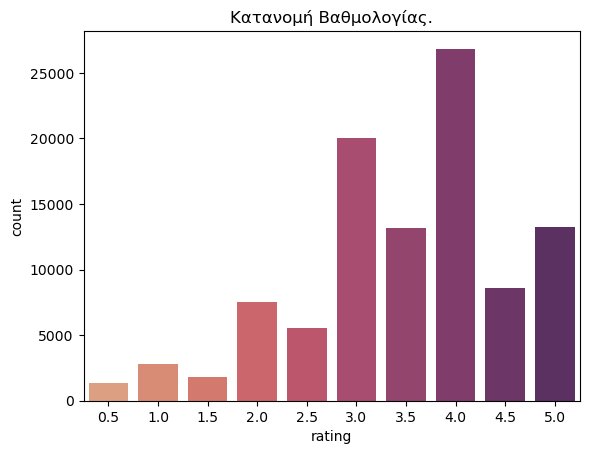

In [ ]:
print(f"Κατανομή Βαθμολογίας: \n{dataset['rating'].value_counts().sort_index(ascending=True)}")

sns.countplot(dataset, x='rating', palette='flare')
plt.title("Κατανομή Βαθμολογίας.", fontsize=12)
print("\n")

# Εκπαίδευση του kMeans μοντέλου, και μέτρηση αποδοτικότητας με RMSE και HitRate.

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from scipy.spatial import Voronoi, voronoi_plot_2d

In [ ]:
user_item_matrix = dataset.pivot(index='userId', columns='movieId', values='rating').fillna(0)
user_item_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
609,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

train_matrix = train_data.pivot(index='userId', columns='movieId', values='rating').fillna(0)
test_matrix = test_data.pivot(index='userId', columns='movieId', values='rating').fillna(0)

NameError: name 'train_test_split' is not defined

In [ ]:
def kmeans_recommendation(user_id, n_clusters=10, top_n=10):
    movie_titles = []
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(user_item_matrix) # get cluster foreach user
    user_cluster = clusters[user_id - 1] # get input user cluster (-1 because list starts with 0)

    similar_users = user_item_matrix.iloc[clusters == user_cluster]
    mean_ratings = similar_users.mean()
    recommended_movies_kmeans = mean_ratings.sort_values(ascending=False).index[:top_n]

    for movie in recommended_movies_kmeans:
        movie_titles.append(movies.loc[movies['movieId'] == movie]['title'].item())
        
    for movie in movie_titles:
        print(movie)
    return kmeans, clusters, recommended_movies_kmeans

def visualise_kmeans(user_id, clusters, kmeans=KMeans):
    pca = PCA(n_components=2)
    user_item_2D = pca.fit_transform(user_item_matrix)
    centroids = kmeans.cluster_centers_
    centroids_2d = pca.transform(centroids)
    
    vor = Voronoi(centroids_2d)
    fig, ax = plt.subplots(figsize=(10, 6))
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, show_points=False)

    # Scatter plot of users
    scatter = ax.scatter(user_item_2D[:, 0], user_item_2D[:, 1], c=clusters, cmap='tab10', alpha=0.6)

    # Highlight user position
    ax.scatter(user_item_2D[user_id - 1, 0], user_item_2D[user_id - 1, 1], 
           color='black', edgecolors='white', s=200, marker='*', label="User ID")

    # Plot centroids and label them with cluster numbers
    for i, (x, y) in enumerate(centroids_2d):
        ax.scatter(x, y, color='red', marker='X', s=100)  # Red 'X' for centroids
        ax.text(x, y, str(i), color='black', fontsize=12, fontweight='bold', ha='center', va='center')
    
user_id = 611
kmeans, clusters, recommended_movies_kmeans = kmeans_recommendation(user_id)
print(f"\nMovies user {user_id} have watched:")
dataset[dataset['userId'] == user_id].sort_values(by='rating', ascending=False).head(20)

Shawshank Redemption, The (1994)
Forrest Gump (1994)
Pulp Fiction (1994)
Silence of the Lambs, The (1991)
Braveheart (1995)
Matrix, The (1999)
Schindler's List (1993)
Star Wars: Episode IV - A New Hope (1977)
Jurassic Park (1993)
Apollo 13 (1995)

Movies user 611 have watched:


,userId,movieId,rating,title,genres
1819,611,260,5.0,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
48125,611,115149,5.0,John Wick (2014),Action|Thriller
48316,611,134130,5.0,The Martian (2015),Adventure|Drama|Sci-Fi
48454,611,166528,5.0,Rogue One: A Star Wars Story (2016),Action|Adventure|Fantasy|Sci-Fi
57275,611,122892,5.0,Avengers: Age of Ultron (2015),Action|Adventure|Sci-Fi
57353,611,122920,5.0,Captain America: Civil War (2016),Action|Sci-Fi|Thriller
57596,611,168252,5.0,Logan (2017),Action|Sci-Fi
38143,611,7153,5.0,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
37232,611,5952,5.0,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
36139,611,4993,5.0,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy


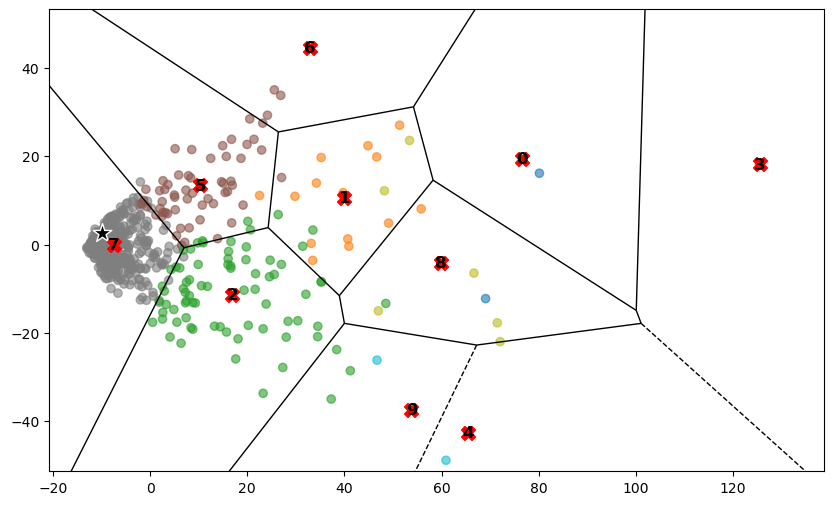

In [ ]:
visualise_kmeans(user_id, clusters, kmeans)

In [ ]:
def evaluate_recommendations(user_id, true_ratings, recommended_movies):
    true_scores = true_ratings[true_ratings['movieId'].isin(recommended_movies)]['rating']
    print(true_scores)
    predicted_scores = [4.0] * len(true_scores) 
    print(predicted_scores) # Υποθέτουμε μέση πρόβλεψη
    
    if len(true_scores) > 0:
        rmse = sqrt(mean_squared_error(true_scores, predicted_scores))
    else:
        rmse = None
    
    hit_rate = len(true_scores) / len(recommended_movies)
    return rmse, hit_rate

true_ratings = dataset[dataset['userId'] == user_id]
rmse_kmeans, hitrate_kmeans = evaluate_recommendations(user_id, true_ratings, recommended_movies_kmeans)

print(f"K-Means: RMSE={rmse_kmeans}, Hit Rate={hitrate_kmeans}")

1819     5.0
3427     4.0
12924    4.5
Name: rating, dtype: float64
[4.0, 4.0, 4.0]
K-Means: RMSE=0.6454972243679028, Hit Rate=0.3


# Εκπαίδευση του KNN μοντέλου, για την δημιουργία του Συστήματος Συστάσεων.

Δημιουργούμε το matrix user_id - title - ratings, για να μπορούμε να συγκρίνουμε ευκολότερα τους χρήστες μεταξύ τους, ανάλογα με τις βαθμολογίες τους για την κάθε ταινία.

In [ ]:
# create a movie-user matrix
X = dataset.copy()
y = dataset['userId']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

user_to_movie_ratings = dataset.pivot(index='userId', columns='movieId', values='rating')
user_to_movie_ratings_nan = X_train.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)

In [ ]:
#cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, recall_score

from scipy.stats import pearsonr
from scipy.spatial.distance import euclidean

cos_sim = cosine_similarity(user_to_movie_ratings_nan)

/home/achintar/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


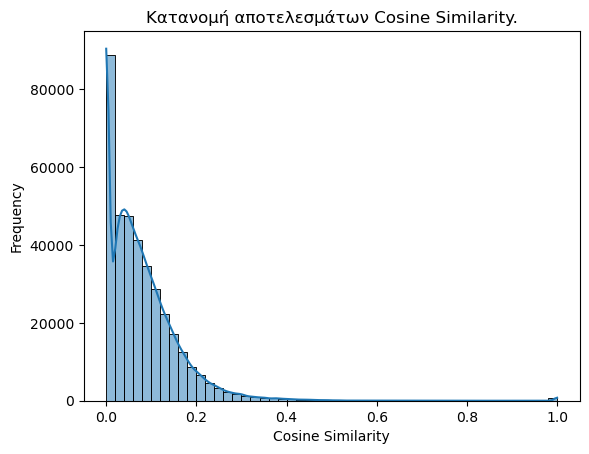

In [ ]:
sns.histplot(cos_sim.flatten(), bins=50, kde=True)
plt.title("Κατανομή αποτελεσμάτων Cosine Similarity.")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# create a sparse csr_matrix for easier fitting.
user_to_movie_csr = csr_matrix(user_to_movie_ratings_nan.values)
dense_matrix = user_to_movie_csr.toarray()
print(dense_matrix)

[[4. 0. 4. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [3. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
knn_model = NearestNeighbors(n_neighbors=10, metric='cosine', algorithm='brute')
knn_model.fit(dense_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=10)

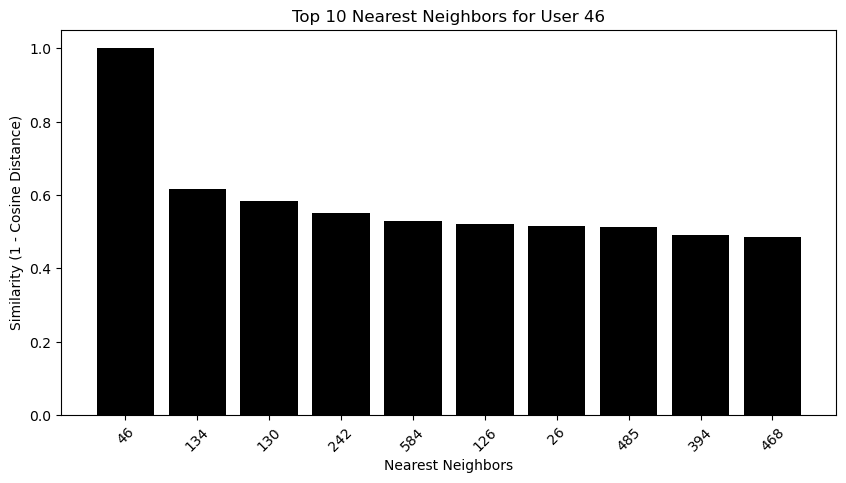

In [ ]:
user_index = user_to_movie_ratings.index.get_loc(46)

knn_input = user_to_movie_ratings_nan.values[user_index].reshape(1, -1)
distances, indices = knn_model.kneighbors(knn_input, n_neighbors=10)


plt.figure(figsize=(10, 5))
plt.bar(range(1, 11), 1 - distances.flatten(), color='black')
plt.xlabel("Nearest Neighbors")
plt.ylabel("Similarity (1 - Cosine Distance)")
plt.title(f"Top 10 Nearest Neighbors for User {user_index+1}")
plt.xticks(range(1, 11), indices.flatten()+1, rotation=45)
plt.show()

In [ ]:
def baseline_model(user_id, movie_id):
    return 3.0

def CF_user_mean(user_id, movie_id, user_similarity, user_item_matrix):
    """
    Collaborative Filtering using the mean rating of the movie.
    
    :param user_id: The user for whom to predict the rating.
    :param movie_id: The movie for which to predict the rating.
    :param user_similarity: Unused argument (for consistency with other CF functions).
    :param user_item_matrix: The user-item rating matrix.
    :return: Predicted rating for the user-movie pair.
    """
    # Check if the movie_id exists in the user_item_matrix
    if movie_id not in user_item_matrix.columns:
        return 3.0  # Default value if movie_id is not found
    
    # Get the ratings for the movie from all users
    movie_ratings = user_item_matrix[movie_id]
    
    # Filter out users who haven't rated the movie
    valid_ratings = movie_ratings[movie_ratings > 0]
    
    # If no valid ratings, return a default value (e.g., 3.0)
    if len(valid_ratings) == 0:
        return 3.0
    
    # Return the mean rating
    return valid_ratings.mean()


def CF_user_wmean_cosine(user_id, movie_id, cos_sim, user_to_movie_ratings, k=20):
    """
    Collaborative Filtering using weighted mean of similar users' ratings,
    weighted by cosine similarity.
    
    :param user_id: The user for whom to predict the rating.
    :param movie_id: The movie for which to predict the rating.
    :param cos_sim: Precomputed user-user cosine similarity matrix.
    :param user_to_movie_ratings: The user-item rating matrix.
    :param k: Number of most similar users to consider.
    :return: Predicted rating for the user-movie pair.
    """
    # Check if the movie_id exists in the user_to_movie_ratings
    if movie_id not in user_to_movie_ratings.columns:
        return 3.0  # Default value if movie_id is not found
    
    # Get the user's similarity scores with all other users
    user_sim_scores = cos_sim[user_id -1]  # Adjust for 0-based index
    
    # Get the ratings for the movie from all users
    movie_ratings = user_to_movie_ratings[movie_id]
    
    # Filter out users who haven't rated the movie
    valid_ratings_mask = movie_ratings > 0
    valid_ratings = movie_ratings[valid_ratings_mask]
    valid_sim_scores = user_sim_scores[valid_ratings_mask]
    
    # If no valid ratings, return a default value (e.g., 3.0)
    if len(valid_ratings) == 0:
        return 3.0
    
    # Sort by similarity and select top-k similar users
    top_k_indices = np.argsort(valid_sim_scores)[-k:]
    
    # access values by integer location
    top_k_ratings = valid_ratings.iloc[top_k_indices]
    top_k_sim_scores = valid_sim_scores[top_k_indices]
    
    # Compute the weighted mean of the top-k ratings
    if top_k_sim_scores.sum() == 0:
        return valid_ratings.mean()  # Fallback to mean if no similarity
    else:
        return np.dot(top_k_ratings, top_k_sim_scores) / top_k_sim_scores.sum()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def score(CF_model, user_similarity, user_item_matrix, threshold=3.5):
    """
    Evaluate the collaborative filtering model using RMSE
    
    CF_model: the collaborative filtering model function
    user_similarity: precomputed user-user similarity matrix
    user_item_matrix: the user-item rating matrix
    return: dict containing RMSE
    """
    # Get user-movie pairs from the test set
    id_pairs = zip(X_test['userId'], X_test['movieId'])
    
    # Generate predictions
    y_pred = np.array([CF_model(user_id, movie_id, user_similarity, user_item_matrix) for (user_id, movie_id) in id_pairs])
    y_true = np.array(X_test['rating'])
    
    # Compute evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Convert ratings to binary classes
    y_true_binary = (y_true >= threshold).astype(int)
    y_pred_binary = (y_pred >= threshold).astype(int)
    
    # Compute classification metrics
    f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)
    accuracy = accuracy_score(y_true_binary, y_pred_binary)
    recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
    
    # Return metrics as a dictionary
    return {
        'RMSE': rmse,
        'F1-score': f1,
        'Accuracy': accuracy,
        'Recall': recall
    }

metrics_mean = score(CF_user_mean, None, user_to_movie_ratings)
metrics_cosine = score(CF_user_wmean_cosine, cos_sim, user_to_movie_ratings)

metrics_comparison = pd.DataFrame({
    'Simple Mean': metrics_mean,
    'Cosine Similarity': metrics_cosine,
})

print(metrics_comparison)


          Simple Mean  Cosine Similarity
RMSE         0.874289           0.666618
F1-score     0.754096           0.838434
Accuracy     0.710236           0.809943
Recall       0.728153           0.808200


In [ ]:
# find most similar users to the input user
def find_similar_users(user_id, user_to_movie_ratings_nan, n = 10):
    if user_id not in user_to_movie_ratings_nan.index:
        print(f"User: {user_id} not found in training data.")
        return [], []
    user_index = user_to_movie_ratings_nan.index.get_loc(user_id)
    knn_input = user_to_movie_ratings_nan.values[user_index].reshape(1, -1)
    distances, indices = knn_model.kneighbors(knn_input, n_neighbors=n)

    similar_users = user_to_movie_ratings_nan.index[indices.flatten()[1:]].tolist()
    similar_distances = distances.flatten()[1:].tolist()
    
    print("Οι πρώτοι", n ,"χρήστες που μοιάζουν με τον χρήστη", user_id , "είναι: ")
    for i in range(1,len(distances[0])):
        print(i,". Χρήστης:", indices[0][i]+1, "μοιάζει με απόσταση: ", (1 - distances[0][i]))
    return similar_users, similar_distances



In [ ]:
def recommend_movies(user_id, top_n):
    similar_users, user_distance = find_similar_users(user_id, user_to_movie_ratings_nan)

    user_movies = set(X_train[X_train['userId'] == user_id]['movieId'])
    
    movie_scores = {}

    for i, sim_user in enumerate(similar_users):
        sim_movies = X_train[X_train['userId'] == sim_user]


        # Remove movies that the target user has already watched
        sim_movies = sim_movies[~sim_movies['movieId'].isin(user_movies)]

        for _, row in sim_movies.iterrows():
            movie_id = row['movieId']
            rating = row['rating']
            weight = 1 / (user_distance[i] + 1e-5)
            
            # Accumulate weighted scores
            if movie_id not in movie_scores:
                movie_scores[movie_id] = 0
            movie_scores[movie_id] += rating * weight
    print(sim_movies)

    # Sort movies by score in descending order
    recommended_movie_ids = sorted(movie_scores, key=movie_scores.get, reverse=True)[:top_n]

    # Ensure unique movie recommendations by dropping duplicates before filtering
    recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)].drop_duplicates(subset='movieId')

    return recommended_movies



In [ ]:
user_id = 126
#movies_list = train_user_movie_ratings.columns

recommended_movies = recommend_movies(user_id, 10)
print(f"\n10 προτάσεις ταινιών:\n {recommended_movies}")

print(f'\n10 ταινίες που είδε ο χρήστης: {user_id}.')
dataset[(dataset['userId'] == user_id)].sort_values(by="rating", ascending=False).head(30)

Οι πρώτοι 10 χρήστες που μοιάζουν με τον χρήστη 126 είναι: 
1 . Χρήστης: 379 μοιάζει με απόσταση:  0.6883092959549962
2 . Χρήστης: 507 μοιάζει με απόσταση:  0.5908057023467995
3 . Χρήστης: 470 μοιάζει με απόσταση:  0.5639824028787368
4 . Χρήστης: 498 μοιάζει με απόσταση:  0.554580338029909
5 . Χρήστης: 584 μοιάζει με απόσταση:  0.5476810973264191
6 . Χρήστης: 134 μοιάζει με απόσταση:  0.544681455552398
7 . Χρήστης: 46 μοιάζει με απόσταση:  0.5204881112186157
8 . Χρήστης: 170 μοιάζει με απόσταση:  0.4942183318264315
9 . Χρήστης: 455 μοιάζει με απόσταση:  0.48631972410861035
       userId  movieId  rating                               title  \
1126      455      151     3.0                      Rob Roy (1995)   
732       455       50     3.0          Usual Suspects, The (1995)   
31205     455      350     4.0                  Client, The (1994)   
25886     455      266     4.0          Legends of the Fall (1994)   
31995     455      435     2.0                    Coneheads (1993)   


,userId,movieId,rating,title,genres
413,126,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
2822,126,367,5.0,"Mask, The (1994)",Action|Comedy|Crime|Fantasy
31522,126,377,5.0,Speed (1994),Action|Romance|Thriller
26369,126,380,5.0,True Lies (1994),Action|Adventure|Comedy|Romance|Thriller
26195,126,364,5.0,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX
16371,126,318,5.0,"Shawshank Redemption, The (1994)",Crime|Drama
3038,126,457,5.0,"Fugitive, The (1993)",Thriller
32130,126,454,5.0,"Firm, The (1993)",Drama|Thriller
2499,126,356,4.0,Forrest Gump (1994),Comedy|Drama|Romance|War
20161,126,595,4.0,Beauty and the Beast (1991),Animation|Children|Fantasy|Musical|Romance|IMAX
